In [0]:
!pip install mediapipe
!pip install git+https://github.com/openai/CLIP.git
!pip install dlib
!pip install protobuf==3.20.3
!pip install pytorch_tabnet


  Obtaining dependency information for mediapipe from https://files.pythonhosted.org/packages/83/92/43e6837d097f8ed35e6ffc4eefe617107963839e5e18136fea463f579baf/mediapipe-0.10.20-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Obtaining dependency information for jax from https://files.pythonhosted.org/packages/f4/58/cc0721a1030fcbab0984beea0bf3c4610ec103f738423cdfa9c4ceb40598/jax-0.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for jaxlib from https://files.pythonhosted.org/packages/58/8e/a5c29db03d5a93b0326e297b556d0e0a9805e9c9c1ae5f82f69557273faa/jaxlib-0.5.0-cp311-cp311-manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/f7/13/756b13b8d5d417a0b4c3bf6ceafb59df0ed05cec7fedc2490bbbf5e60ebc/opencv_contrib_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for protobuf<5,>=4.25.3 from https://files.pythonhosted.org/

In [0]:
from pyspark.sql import SparkSession

# Start Spark Session
spark = SparkSession.builder \
    .appName("PySparkWithExternalPackages") \
    .config("spark.executorEnv.PYTHONPATH", "/usr/local/lib/python3.10/dist-packages") \
    .config("spark.pyspark.python", "python3") \
    .config("spark.pyspark.driver.python", "python3") \
    .getOrCreate()

print("Spark session started successfully.")


Spark session started successfully.


In [0]:
import os
import shutil
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from IPython.display import FileLink, HTML
import logging
import requests
from io import BytesIO
import cv2
import dlib
import mediapipe
import math
import torch
import clip



2025-01-28 21:59:11.032662: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 21:59:11.110758: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 21:59:11.435337: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 21:59:15.523730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [0]:
#Load the data set
union_df_path = "/dbfs/FileStore/Data_NotNorm__1_.csv"
# Reading CSV files into DataFrames
union_df = pd.read_csv(union_df_path)

In [0]:
# עדכון הערכים בעמודה "tilt your head" כך שהערך החדש יהיה הערך הנוכחי פחות 1
union_df["tilt your head"] = 1 - union_df["tilt your head"] 

# שינוי שם העמודה כך שהיא תתחיל ב"DONT"
union_df.rename(columns={"tilt your head": "don't tilt your head"}, inplace=True)

print(union_df.columns)

Index(['smile', 'wear professional Attire', 'use clean background',
       'look serious', 'show your face clearly', 'use formal expression',
       'wear suit', 'look confidence', 'look approachability',
       'don't look emotional', 'crop the picture', 'avoid noise or artifacts',
       'use positive atmosphere', 'use corporate environment',
       'look trustworthiness', 'be energetic', 'look distinctive', 'look calm',
       'fix your hair', 'show your face more', 'show your body more',
       'put your face horizontally in the center',
       'put your face vertically in the center', 'don't tilt your head',
       'use eye contact', 'use high resolution', 'use good lighting',
       'use color harmony in the pic', 'use lighting quality', 'LABEL'],
      dtype='object')


In [0]:
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [0]:
# Define a Residual Block class
class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        # Define the layers for the residual block
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(output_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv1d(output_channels, output_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(output_channels)

        self.conv3 = nn.Conv1d(output_channels, output_channels, kernel_size, stride, padding)
        self.bn3 = nn.BatchNorm1d(output_channels)

        # Define a downsample layer if the number of channels changes
        self.downsample = nn.Conv1d(input_channels, output_channels, kernel_size=1, stride=1) \
            if input_channels != output_channels else None

    def forward(self, x):
        # Save the input for the residual connection
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        # Pass through the layers
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Add the residual connection
        out += identity
        out = self.relu(out)
        return out

# Define the main model class
class LinkedInScorePredictor(nn.Module):
    def __init__(self, input_dim):
        super(LinkedInScorePredictor, self).__init__()
        self.input_dim = input_dim

        # Initial convolutional layer
        self.initial_conv = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.initial_bn = nn.BatchNorm1d(16)
        self.initial_relu = nn.ReLU()

        # Two residual blocks
        self.res_block1 = ResidualBlock(16, 32)
        self.res_block2 = ResidualBlock(32, 64)

        # Global pooling to reduce feature dimensions
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers for final predictions
        self.fc_layers = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # Final output for predicting score
        )

    def forward(self, x):
        # Add a channel dimension for Conv1D
        x = x.unsqueeze(1)

        # Pass through initial convolutional layer
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)

        # Pass through the residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)

        # Apply global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Pass through fully connected layers
        x = self.fc_layers(x)
        return x


In [0]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, StringType
from transformers import pipeline
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [0]:
# Install the required packages
%pip install opencv-python-headless mediapipe

  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/dd/5c/c139a7876099916879609372bfa513b7f1257f7f1a908b0bdc1c2328241b/opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for protobuf<5,>=4.25.3 from https://files.pythonhosted.org/packages/d4/f0/6d5c100f6b18d973e86646aa5fc09bc12ee88a28684a56fd95511bceee68/protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/50.0 MB ? eta -:--:--
   ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/50.0 MB 31.2 MB/s eta 0:00:02
   ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/50.0 MB 107.9 MB/s eta 0:00:01
   ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/50.0 MB 168.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/50.0 MB 144.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━╸━

In [0]:
pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zcz191o6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zcz191o6
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

!pip install torch

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import clip
import torch
from PIL import Image

# Device selection
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model and preprocessing pipeline
Clip_model, Clip_preprocess = clip.load("ViT-B/32", device=device)

# Confirm successful loading
print("CLIP model and preprocessing pipeline loaded successfully.")


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 248MiB/s]


CLIP model and preprocessing pipeline loaded successfully.


In [0]:
%pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/2c/8b/90eb44a40476fa0e71e05a0283947cfd74a5d36121a11d926ad6f3193cc4/opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/63.0 MB ? eta -:--:--
   ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/63.0 MB 72.7 MB/s eta 0:00:01
   ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/63.0 MB 143.4 MB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/63.0 MB 211.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/63.0 MB 209.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 31.5/63.0 MB 207.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 38.8/63.0 MB 208.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 45.8/63.0 MB 205.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 52.7/63.0 MB 202.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [0]:
%pip install opencv-contrib-python


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import numpy as np
import cv2
import dlib
import mediapipe
import math
import torch
import clip
from PIL import Image
from io import BytesIO

# Define the path to your local directory
# output_directory = "/dbfs/FileStore/all_images_combined"

# -------------
# HELPER LOAD FUNCTION
# -------------

def load_local_image(image_filename):
    """
    Load an image from the local directory `output_directory`.
    Returns a NumPy array (BGR) suitable for OpenCV.
    """
    # Construct the full path
    full_path = os.path.join(output_directory, image_filename)
    # Use PIL to open, then convert to NumPy (as OpenCV usually uses BGR)
    pil_image = Image.open(full_path).convert("RGB")
    img_array = np.array(pil_image)
    # Convert RGB (PIL) to BGR (OpenCV)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    return img_array


# -------------
# Example CLIP-related functions (requires correct CLIP setup)
# -------------

# NOTE: This part requires that you have a CLIP model loaded in memory:
#       - device = ...
#       - Clip_model, Clip_preprocess = ...
#       - clip = ...
# Adapt these as needed in your environment.

def check_single_feature(image_filename, prompt_yes, prompt_no):
    """
    Check a single feature using CLIP text-image similarity.

    Args:
        image_filename (str): The file name of the image (not URL).
        prompt_yes (str): Positive prompt text.
        prompt_no (str): Negative prompt text.

    Returns:
        dict: Dictionary containing prompt_yes score, prompt_no score, final_decision.
    """
    # Load image from local path
    full_path = os.path.join(output_directory, image_filename)
    pil_img = Image.open(full_path).convert("RGB")
    
    # Preprocess for CLIP and move to device
    image = Clip_preprocess(pil_img).unsqueeze(0).to(device)

    # Prepare prompts
    text_prompts = [prompt_yes, prompt_no]
    text = clip.tokenize(text_prompts).to(device)

    # Compute similarity
    with torch.no_grad():
        image_features = Clip_model.encode_image(image)
        text_features = Clip_model.encode_text(text)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    scores = similarities.cpu().numpy().flatten()
    result = {
        "prompt_yes": f"{prompt_yes}: {scores[0]:.2f}%",
        "prompt_no": f"{prompt_no}: {scores[1]:.2f}%",
        "final_decision": "Yes" if scores[0] > scores[1] else "No"
    }
    return result


# -------------
# BODY PROPORTION
# -------------

def calculate_body_proportion(image_filename):
    """
    Calculate the proportion of the body (as detected by MediaPipe Pose) relative to the image size.
    """
    import mediapipe as mp

    # Load local image
    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_pose = mp.solutions.pose
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        results = pose.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

        if not results.pose_landmarks:
            print("No body detected.")
            return 0

        body_landmarks = results.pose_landmarks.landmark
        x_coords = [min(max(lm.x, 0), 1) * w for lm in body_landmarks]
        y_coords = [min(max(lm.y, 0), 1) * h for lm in body_landmarks]

        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)

        body_width = x_max - x_min
        body_height = y_max - y_min
        body_area = body_width * body_height
        image_area = w * h

        proportion = body_area / image_area
        return proportion


# -------------
# NOSE CENTER SCORE
# -------------

def calculate_nose_center_score(image_filename):
    """
    Calculate how close the nose (landmark) is to the image center in x-dimension.
    """
    import dlib
    import mediapipe as mp

    # Load local image as PIL
    full_path = os.path.join(output_directory, image_filename)
    try:
        pil_img = Image.open(full_path).convert("RGB")
    except Exception as e:
        raise Exception(f"Failed to load image from local path: {e}")

    img_array = np.array(pil_img)
    img_height, img_width = img_array.shape[:2]
    image_center_x = img_width / 2

    # Try Dlib first
    try:
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(dlib.data_file("shape_predictor_68_face_landmarks.dat"))
        faces = detector(img_array, 1)

        if len(faces) > 0:
            face = faces[0]
            landmarks = predictor(img_array, face)
            # Landmark 30 is the nose tip
            nose_x = landmarks.part(30).x

            normalized_distance_x = abs(nose_x - image_center_x) / img_width
            return normalized_distance_x
    except Exception:
        print("Dlib failed to detect nose. Trying with MediaPipe...")

    # Fallback to MediaPipe
    try:
        mp_face_mesh = mp.solutions.face_mesh
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
            results = face_mesh.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

            if not results.multi_face_landmarks:
                return 0

            # Nose tip index in MediaPipe is 1
            face_landmarks = results.multi_face_landmarks[0]
            nose_x = face_landmarks.landmark[1].x * img_width

            normalized_distance_x = abs(nose_x - image_center_x)
            return normalized_distance_x
    except Exception as e:
        print(f"MediaPipe failed: {e}")
        return 0


# -------------
# FACE PROPORTIONS
# -------------

def calculate_face_proportions(image_filename):
    """
    Calculate what fraction of the image area is occupied by the detected face(s).
    """
    import mediapipe as mp

    # Load local image
    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_face_detection = mp.solutions.face_detection
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

        if not results.detections:
            return 0

        total_face_area = 0
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            x, y, width, height = bboxC.xmin, bboxC.ymin, bboxC.width, bboxC.height
            total_face_area += (width * w) * (height * h)

        image_area = h * w
        proportion = total_face_area / image_area
        return proportion


# -------------
# CENTER SCORE Y-AXIS
# -------------

def calculate_center_score_y_axis(image_filename):
    """
    Returns how close the nose tip is to the vertical center of the image (score 0-1).
    """
    import mediapipe as mp

    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return 0

        face_landmarks = results.multi_face_landmarks[0]
        nose_tip_index = 1  # nose tip
        nose_tip_y = face_landmarks.landmark[nose_tip_index].y * h
        image_center_y = h / 2

        normalized_distance_y = abs(nose_tip_y - image_center_y) / (h / 2)
        score = max(0, 1 - normalized_distance_y)
        return score


# -------------
# CENTER SCORE X-AXIS
# -------------

def calculate_center_score_x_axis(image_filename):
    """
    Returns how centered the eye region is horizontally (score 0-1).
    """
    import mediapipe as mp

    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return 0

        face_landmarks = results.multi_face_landmarks[0]
        left_eye_indices = [33, 160, 158]
        right_eye_indices = [362, 385, 387]

        left_eye = np.mean([(face_landmarks.landmark[i].x * w,
                             face_landmarks.landmark[i].y * h) for i in left_eye_indices], axis=0)
        right_eye = np.mean([(face_landmarks.landmark[i].x * w,
                              face_landmarks.landmark[i].y * h) for i in right_eye_indices], axis=0)

        image_center_x = w / 2
        eye_center_x = (left_eye[0] + right_eye[0]) / 2

        normalized_distance = abs(eye_center_x - image_center_x) / (w / 2)
        score = max(0, 1 - normalized_distance)
        return score


# -------------
# TILT HEAD
# -------------

def calculate_tilt_head(image_filename):
    """
    Calculate how tilted the head is (in degrees) based on the eye line.
    Returns a normalized tilt score (0-??).
    """
    import mediapipe as mp

    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return 0

        face_landmarks = results.multi_face_landmarks[0]
        left_eye_indices = [33, 160, 158]
        right_eye_indices = [362, 385, 387]

        left_eye = np.mean([(face_landmarks.landmark[i].x * w,
                             face_landmarks.landmark[i].y * h) for i in left_eye_indices], axis=0)
        right_eye = np.mean([(face_landmarks.landmark[i].x * w,
                              face_landmarks.landmark[i].y * h) for i in right_eye_indices], axis=0)

        delta_x = right_eye[0] - left_eye[0]
        delta_y = right_eye[1] - left_eye[1]
        tilt_angle_radians = np.arctan2(delta_y, delta_x)
        tilt_angle_degrees = np.degrees(tilt_angle_radians)

        # Example normalization: compare to a max tilt of 30 degrees
        max_tilt = 30.0
        normalized_tilt_score = max(0, abs(tilt_angle_degrees) / max_tilt)
        return normalized_tilt_score


# -------------
# LOOKING DIRECTION
# -------------

def calculate_looking_direction_score(image_filename):
    """
    Estimate if the person is looking at the camera (eye alignment with nose).
    Returns a score 0-1 (1 = direct look).
    """
    import mediapipe as mp

    img_array = load_local_image(image_filename)
    h, w, _ = img_array.shape

    mp_face_mesh = mp.solutions.face_mesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return 0

        face_landmarks = results.multi_face_landmarks[0]
        left_eye_indices = [33, 160, 158]
        right_eye_indices = [362, 385, 387]
        nose_tip_index = 1

        left_eye = np.mean([(face_landmarks.landmark[i].x * w,
                             face_landmarks.landmark[i].y * h) for i in left_eye_indices], axis=0)
        right_eye = np.mean([(face_landmarks.landmark[i].x * w,
                              face_landmarks.landmark[i].y * h) for i in right_eye_indices], axis=0)
        nose_tip = face_landmarks.landmark[nose_tip_index]
        nose_tip = (nose_tip.x * w, nose_tip.y * h)

        eye_center_x = (left_eye[0] + right_eye[0]) / 2
        delta_x = abs(nose_tip[0] - eye_center_x)

        # Example threshold for 0 score:
        max_delta = w * 0.05
        normalized_score = max(0, 1 - (delta_x / max_delta))
        return normalized_score


# -------------
# FACE COORD DETECTION
# -------------

def detect_face_coordinates(image_filename):
    """
    Detect face coordinates using Mediapipe. Return (x_min, y_min, x_max, y_max).
    """
    import mediapipe as mp

    mp_face_detection = mp.solutions.face_detection
    face_detector = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    # Load local image
    pil_img = Image.open(os.path.join(output_directory, image_filename)).convert("RGB")
    img_array = np.array(pil_img)

    results = face_detector.process(img_array)
    if results.detections:
        detection = results.detections[0]
        bboxC = detection.location_data.relative_bounding_box
        h, w, _ = img_array.shape
        x_min = int(bboxC.xmin * w)
        y_min = int(bboxC.ymin * h)
        x_max = x_min + int(bboxC.width * w)
        y_max = y_min + int(bboxC.height * h)
        return (x_min, y_min, x_max, y_max)

    return None


# -------------
# DPI SCORE
# -------------

def calculate_dpi_score(image_filename):
    """
    Approximate resolution-based score.
    """
    from PIL import Image

    img = Image.open(os.path.join(output_directory, image_filename))
    width, height = img.size
    total_pixels = width * height

    # Example base: 480 x 360 (172800 pixels)
    max_pixels = 480 * 360
    normalized_score = min(total_pixels / max_pixels, 1)
    return normalized_score


# -------------
# BACKGROUND BRIGHTNESS
# -------------

def calculate_background_brightness(image_filename):
    """
    Estimate overall brightness of the image. Returns a normalized brightness (0-1).
    """
    img_array = load_local_image(image_filename)

    # Convert BGR to RGB for standard brightness formula
    rgb_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    # brightness ~ 0.299*R + 0.587*G + 0.114*B
    brightness = 0.299 * rgb_array[:, :, 0] + \
                 0.587 * rgb_array[:, :, 1] + \
                 0.114 * rgb_array[:, :, 2]

    overall_brightness = np.mean(brightness)
    # Example normalization factor
    X = 180.0
    normalized_brightness = overall_brightness / X
    clamped_brightness = min(normalized_brightness, 1)
    return clamped_brightness


# -------------
# MAIN FEATURE SCORES AGGREGATOR
# -------------

def feature_scores(image_filename):
    """
    Runs a set of checks on the image file and returns a dictionary of scores.
    """
    feature_checks = [
        {"name": "smile", "prompt_yes": "smile", "prompt_no": "Else"},
        {"name": "wear professional Attire", "prompt_yes": "person with professional Attire", "prompt_no": "Else"},
        {"name": "use clean background", "prompt_yes": "clean background", "prompt_no": "aggressive background that steals all the attention"},
        {"name": "look serious", "prompt_yes": "serious", "prompt_no": "Silly"},
        {"name": "show your face clearly", "prompt_yes": "clearly contains a face", "prompt_no": "Else"},
        {"name": "use formal expression", "prompt_yes": "job expressions", "prompt_no": "Else"},
        {"name": "wear suit", "prompt_yes": "person with suit", "prompt_no": "casual outfit"},
        {"name": "look confidence", "prompt_yes": "confident person", "prompt_no": "Else"},
        {"name": "look approachability", "prompt_yes": "friendly", "prompt_no": "Else"},
        {"name": "don't look emotional", "prompt_yes": "neutral expression", "prompt_no": "emotional expression"},
        {"name": "crop the picture", "prompt_yes": "good image frame/lines", "prompt_no": "aggressively cut image"},
        {"name": "avoid noise or artifacts", "prompt_yes": "no noise and artifacts", "prompt_no": "Else"},
        {"name": "use positive atmosphere", "prompt_yes": "positive atmosphere", "prompt_no": "Negative atmosphere"},
        {"name": "use corporate environment", "prompt_yes": "office", "prompt_no": "Else"},
        {"name": "look trustworthiness", "prompt_yes": "trustworthy", "prompt_no": "untrust"},
        {"name": "be energetic", "prompt_yes": "positive energey", "prompt_no": "unwelcoming"},
        {"name": "look distinctive", "prompt_yes": "distinct and memorable", "prompt_no": "Regular"},
        {"name": "look calm", "prompt_yes": "calm", "prompt_no": "Upset"},
        {"name": "fix your hair", "prompt_yes": "neat hair", "prompt_no": "messy hair"},
        {"name": "show your face more", "prompt_yes": "whole face", "prompt_no": "cover face"},
        {"name": "show your body more", "prompt_yes": "head and shoulder", "prompt_no": "cant see shoulder"},
        {"name": "put your face horizontally in the center", "prompt_yes": "person in middle", "prompt_no": "too far to the side"},
        {"name": "put your face vertically in the center", "prompt_yes": "person in middle", "prompt_no": "too far vertucally"},
        {"name": "tilt your head", "prompt_yes": "straight head", "prompt_no": "Else"},
        {"name": "use eye contact", "prompt_yes": "looking to the camera", "prompt_no": "eyes off camera"},
        {"name": "use high resolution", "prompt_yes": "clear", "prompt_no": "blurry"},
        {"name": "use good lighting", "prompt_yes": "good lighting", "prompt_no": "bad lighting"},
        {"name": "use color harmony in the pic", "prompt_yes": "Colorful image", "prompt_no": "Monochromatic image"},
      
    ]





    scores = {}
    all_results = {}

    # 1) Use CLIP-based checks
    for check in feature_checks:
        # Will return a dictionary like:
        # {
        #   "prompt_yes": "some text: 12.34%",
        #   "prompt_no": "some text: 87.66%",
        #   "final_decision": "Yes" or "No"
        # }
        result = check_single_feature(image_filename, check["prompt_yes"], check["prompt_no"])
        all_results[check["name"]] = result

    # Extract the "Yes" percentage for each feature
    for feature_name, result in all_results.items():
        yes_score_str = result["prompt_yes"].split(":")[1].strip().replace('%', '')
        yes_score = float(yes_score_str)
        scores[feature_name] = yes_score

    # 2) If face_proportion is not 0, override or supplement that feature
    fp = calculate_face_proportions(image_filename)
    if fp != 0:
        scores["show your face more"] = fp

    bp = calculate_body_proportion(image_filename)
    if bp != 0:
        scores["show your body more"] = bp

    cscore_x = calculate_center_score_x_axis(image_filename)
    if cscore_x != 0:
        scores["put your face horizontally in the center"] = cscore_x

    cscore_y = calculate_center_score_y_axis(image_filename)
    if cscore_y != 0:
        scores["put your face vertically in the center"] = cscore_y

    tilt = calculate_tilt_head(image_filename)
    if tilt != 0:
        scores["tilt your head"] = tilt

    looking_dir = calculate_looking_direction_score(image_filename)
    if looking_dir != 0:
        scores["use eye contact"] = looking_dir

    # 3) Additional numeric scores
    scores["use high resolution"] = calculate_dpi_score(image_filename)
    scores["use lighting quality"] = calculate_background_brightness(image_filename)
    # If you had a colorfulness or sharpness measure, you can add them similarly.

    return scores


In [0]:
# Load the model state dict
input_dim = 28 #as defined in the model
model = LinkedInScorePredictor(input_dim)  # Replace with your model class
model.load_state_dict(torch.load("/dbfs/models/linkedin_score_predictor.pth"))
model.eval()

LinkedInScorePredictor(
  (initial_conv): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (initial_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (initial_relu): ReLU()
  (res_block1): ResidualBlock(
    (conv1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
  )
  (res_block2): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True,

In [0]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = כל ההודעות, 1 = אזהרות, 2 = שגיאות, 3 = שקט

In [0]:
import logging
logging.getLogger("torch").setLevel(logging.ERROR)


Image downloaded and saved to /root/downloaded_images/single_image.jpeg


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1738101642.887907    4385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738101642.998293    4391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738101643.049178    4391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738101643.072943    4390 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
W0000 00:00:1738101643.098910    4397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:

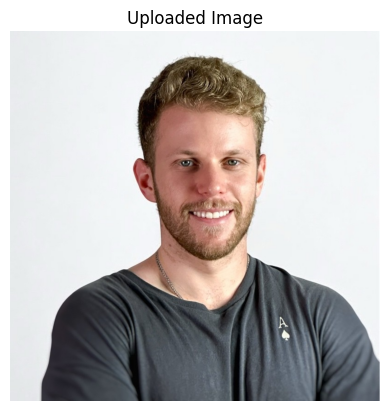

Your score is: 92.181
Top features to improve:
- Use a corporate-style background
  Current value: 0.290, Suggested value: 0.950
  Expected improvement in score: 7.656
- Look approachable
  Current value: 0.340, Suggested value: 0.650
  Expected improvement in score: 4.831
- Avoid noise or visual artifacts
  Current value: 0.440, Suggested value: 0.700
  Expected improvement in score: 2.875


In [0]:
import os
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import torch
import matplotlib.pyplot as plt

# Friendly feature names mapping
friendly_feature_names = {
    "put your face horizontally in the center": "Center your face horizontally in the photo",
    "use clean background": "Use a clean, clutter-free background with no distraction",
    "look calm": "Keep a calm and composed expression",
    "use good lighting": "The image might be too bright, Ensure bright, balanced lighting",
    "look trustworthiness": "Appear trustworthy",
    "look serious": "Adopt a professional, serious look",
    "don't look emotional": "Avoid overly emotional expressions",
    "wear professional Attire": "Dress in professional attire",
    "smile": "Smile naturally to appear approachable",
    "use positive atmosphere": "Create a positive, inviting atmosphere",
    "use high resolution": "Use a high-resolution image",
    "don't tilt your head": "Keep your head straight",
    "show your body more": "Show more of your upper body",
    "use eye contact": "Make direct eye contact",
    "show your face more": "Ensure your face is clearly visible",
    "look approachability": "Look approachable",
    "use corporate environment": "Use a corporate-style background",
    "look confidence": "Project confidence",
    "crop the picture": "Crop the picture to focus on your face",
    "wear suit": "Consider wearing a suit",
    "be energetic": "Appear energetic",
    "look distinctive": "Stand out with a unique style",
    "use color harmony in the pic": "Maintain color harmony",
    "put your face vertically in the center": "Center your face vertically in the photo",
    "avoid noise or artifacts": "Avoid noise or visual artifacts",
    "fix your hair": "Style your hair neatly",
    "use lighting quality": "Improve lighting quality",
    "use formal expression": "Use a formal expression",
    "show your face clearly": "Ensure your face is well-lit and clear",
    "tilt your head": "Tilt your head to the center of the frame"
}

def suggest_best_improvements(model, person_scores, top_n=3):
    """
    Suggest the top N features to improve LinkedIn score.
    Args:
        model: The trained model for predicting LinkedIn score.
        person_scores: Dictionary with person's feature scores.
        top_n: Number of top features to suggest for improvement (default: 3).
    Returns:
        Current score and list of top N suggestions with their improvements.
    """
    test_values = list(np.arange(0.0, 1.0, 0.05))
    base_features = {key: value for key, value in person_scores.items() if key != "LABEL" }

    # Predict current score
    base_tensor = torch.tensor([list(base_features.values())], dtype=torch.float32)
    current_score = model(base_tensor).item()

    improvements = []

    # Iterate over features to find the best improvements
    for feature in base_features.keys():
        if feature == "Appear trustworthy" or feature == "Appear energetic" :
            continue



        best_improvement = 0
        best_value = None

        for value in test_values:
            improved_features = base_features.copy()
            improved_features[feature] = value

            # Predict improved score
            improved_tensor = torch.tensor([list(improved_features.values())], dtype=torch.float32)
            improved_score = model(improved_tensor).item()

            # Calculate improvement
            score_increase = improved_score - current_score 

            if score_increase > best_improvement and value > base_features[feature]:
                best_improvement = score_increase
                if best_improvement + current_score > 100 - 15 :
                    best_improvement = 100 -15- current_score
                best_value = value

        if best_improvement > 0:
            improvements.append((feature, best_improvement, base_features[feature], best_value))

    # Sort improvements by their impact and return the top N
    improvements.sort(key=lambda x: x[1], reverse=True)
    return current_score, improvements[:top_n]

def rename_features(scores):
    """
    Rename features using friendly names.
    Args:
        scores: Dictionary of feature scores.
    Returns:
        Renamed dictionary with friendly feature names.
    """
    renamed_scores = {}
    for key, value in scores.items():
        friendly_name = friendly_feature_names.get(key, key)
        renamed_scores[friendly_name] = value
    return renamed_scores

# Download and process the image
image_url = "https://media.licdn.com/dms/image/v2/D4D03AQGKV06sgU5I0w/profile-displayphoto-shrink_400_400/profile-displayphoto-shrink_400_400/0/1720856224785?e=1743638400&v=beta&t=yRyly5eVAx5LJY3a_ov7rHMGrlKTS2fFuyYld9JXWOk"
output_directory = os.path.expanduser("~/downloaded_images")
os.makedirs(output_directory, exist_ok=True)
save_path = os.path.join(output_directory, "single_image.jpeg")

try:
    response = requests.get(image_url)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content))
    image.save(save_path)
    print(f"Image downloaded and saved to {save_path}")
except Exception as e:
    print(f"Failed to download or save the image: {e}")

# Example: Process the saved image
try:
    person_scores = feature_scores(save_path)  # Assume this extracts feature scores
    person_scores = rename_features(person_scores)

    current_score, top_improvements = suggest_best_improvements(model, person_scores, top_n=3)
    residual = 100 - max(union_df["LABEL"])  # TODO: Adjust residual logic as needed
    current_score = min(current_score + residual, 100)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()

    print(f"Your score is: {current_score:.3f}")
    print("Top features to improve:")
    for feature, improvement, curr_value, best_value in top_improvements:
        friendly_feature = friendly_feature_names.get(feature, feature)
        print(f"- {friendly_feature}")
        print(f"  Current value: {curr_value:.3f}, Suggested value: {best_value:.3f}")
        print(f"  Expected improvement in score: {improvement:.3f}")

except Exception as e:
    print(f"Failed to process the image: {e}")


In [0]:
def get_feedback_from_model(image_url):
    import os
    import requests
    from io import BytesIO
    from PIL import Image
    import matplotlib.pyplot as plt

    output_directory = os.path.expanduser("~/downloaded_images")
    os.makedirs(output_directory, exist_ok=True)
    save_path = os.path.join(output_directory, "single_image.jpeg")
    output_text = ""

    try:
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        image.save(save_path)
        output_text += f"Image downloaded and saved to {save_path}\n"
    except Exception as e:
        return f"Failed to download or save the image: {e}"

    try:
        person_scores = feature_scores(save_path)  # Assume this extracts feature scores
        person_scores = rename_features(person_scores)

        current_score, top_improvements = suggest_best_improvements(model, person_scores, top_n=3)
        residual = 100 - max(union_df["LABEL"])  # TODO: Adjust residual logic as needed
        current_score = min(current_score + residual, 100)

        # Generate the plot (optional, no return needed for visual output)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Uploaded Image")
        plt.show()

        output_text += f"Your score is: {current_score:.3f}\n"
        output_text += "Top features to improve:\n"
        for feature, improvement, curr_value, best_value in top_improvements:
            friendly_feature = friendly_feature_names.get(feature, feature)
            output_text += f"- {friendly_feature}\n"
            output_text += f"  Current value: {int(curr_value)}, Suggested value: {int(best_value)}\n"
            if current_score+improvement  > 100:
                 improvement = 100 - current_score
            output_text += f"  Expected improvement in score: {improvement:.3f}\n"

    except Exception as e:
        return f"Failed to process the image: {e}"

    return output_text


In [0]:
# Create a specific directory to save ngrok.zip
!mkdir -p /tmp/ngrok

# Download ngrok.zip into the specified directory
!wget -O /tmp/ngrok/ngrok.zip https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-stable-linux-amd64.zip

# Verify the download
!ls -l /tmp/ngrok/ngrok.zip


--2025-01-28 22:00:54--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 99.83.220.108, 75.2.60.68, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14949170 (14M) [application/octet-stream]
Saving to: ‘/tmp/ngrok/ngrok.zip’

/tmp/ngrok/ngrok.zi 100%[===================>]  14.26M  94.6MB/s    in 0.2s    

2025-01-28 22:00:55 (94.6 MB/s) - ‘/tmp/ngrok/ngrok.zip’ saved [14949170/14949170]

-rw-r--r-- 1 root root 14949170 Jan 28 22:00 /tmp/ngrok/ngrok.zip


In [0]:
# Navigate to the directory
!cd /tmp/ngrok

# Extract ngrok.zip
!unzip -o /tmp/ngrok/ngrok.zip -d /tmp/ngrok

# Verify the extracted ngrok binary
!ls -l /tmp/ngrok/ngrok

# Make the binary executable
!chmod +x /tmp/ngrok/ngrok

# Authenticate ngrok
!/tmp/ngrok/ngrok authtoken <your_ngrok_token>



Archive:  /tmp/ngrok/ngrok.zip
  inflating: /tmp/ngrok/ngrok        
-rwxr-xr-x 1 root root 47079576 Jan 23 17:10 /tmp/ngrok/ngrok
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [0]:
!pip install flask==3.1.0 werkzeug==3.1.3 --upgrade


  Obtaining dependency information for flask==3.1.0 from https://files.pythonhosted.org/packages/af/47/93213ee66ef8fae3b93b3e29206f6b251e65c97bd91d8e1c5596ef15af0a/flask-3.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for werkzeug==3.1.3 from https://files.pythonhosted.org/packages/52/24/ab44c871b0f07f491e5d2ad12c9bd7358e527510618cb1b803a88e986db1/werkzeug-3.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for itsdangerous>=2.2 from https://files.pythonhosted.org/packages/04/96/92447566d16df59b2a776c0fb82dbc4d9e07cd95062562af01e408583fc4/itsdangerous-2.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for click>=8.1.3 from https://files.pythonhosted.org/packages/7e/d4/7ebdbd03970677812aac39c869717059dbb71a4cfc033ca6e5221787892c/click-8.1.8-py3-none-any.whl.metadata
  Obtaining dependency information for blinker>=1.9 from https://files.pythonhosted.org/packages/10/cb/f2ad4230dc2eb1a74edf38f1a38b9b52277f75bef262d8908e60d957e13c/blinker-1.

In [0]:
from flask import Flask, request, render_template_string, send_from_directory
import os
import threading
from werkzeug.utils import secure_filename
import subprocess
import time
import json

# Initialize Flask app
app = Flask("app", template_folder='/tmp/templates', static_folder='/tmp/static')

# Configure upload folder
UPLOAD_FOLDER = '/tmp/uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# HTML template with proper formatting
html_template = """
<!doctype html>
<html>
<head>
    <title>Image Evaluation App</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #F3F2EF; /* LinkedIn background */
            color: #1D2226; /* Text color */
            margin: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
        }
        .container {
            background: white;
            padding: 30px;
            border-radius: 10px;
            box-shadow: 0px 4px 10px rgba(0, 0, 0, 0.1);
            text-align: center;
            width: 50%;
            min-width: 400px;
        }
        img {
            max-width: 300px;
            height: auto;
            border: 2px solid #0077B5;
            border-radius: 10px;
        }
        button {
            background-color: #0077B5;
            color: white;
            border: none;
            padding: 12px 20px;
            font-size: 16px;
            cursor: pointer;
            border-radius: 5px;
            font-weight: bold;
            margin-top: 15px;
        }
        button:hover {
            background-color: #004471;
        }
        h1, h2 {
            color: #0077B5;
        }
        p {
            font-size: 16px;
        }
        .tips-container {
            text-align: center;
            margin-top: 20px;
        }
        .tip {
            margin-bottom: 15px;
            padding: 15px;
            background-color: #1D2226;
            color: white;
            border-radius: 8px;
            display: inline-block;
            width: 80%;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Image Evaluation App</h1>
        <p>Upload an image and click "Evaluate" to see the grade and tips for improvement.</p>
        <form method="post" enctype="multipart/form-data">
            <input type="file" name="file">
            <br><br>
            <button type="submit">Evaluate</button>
        </form>
        {% if image_url %}
        <h2>Uploaded Image:</h2>
        <img src="{{ image_url }}" alt="Uploaded Image">
        {% if score %}
            <h2>Grade:</h2>
            <p><strong>{{ "%.1f"% score }}%</strong></p>
            <h2>Tips:</h2>
            <div class="tips-container">
                {% for feature, improvement, curr_value, best_value in top_improvements %}
                    <div class="tip">
                        <p><strong>{{ feature }}</strong></p>
                        <p>Current value: {{ "%.2f" % curr_value }}, Suggested value: {{ "%.2f" % best_value }}</p>
                        <p>Expected improvement in score: {{ "%.2f" % improvement }}%</p>
                    </div>
                {% endfor %}
            </div>
        {% elif error_message %}
            <h2>Error:</h2>
            <p>{{ error_message }}</p>
        {% endif %}
        {% endif %}
    </div>
</body>
</html>
"""

@app.route('/', methods=['GET', 'POST'])
def upload_image():
    image_url = None
    score = None
    top_improvements = None
    error_message = None

    if request.method == 'POST':
        if 'file' not in request.files:
            return render_template_string(html_template)

        file = request.files['file']
        if file.filename == '':
            return render_template_string(html_template)

        if file:
            # Save the uploaded file
            filename = secure_filename(file.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            image_url = f"/uploads/{filename}"

            try:
                # Process the image and get model results
                person_scores = feature_scores(filepath)  # Replace with actual scoring logic
                person_scores = rename_features(person_scores)

                # Calculate the score and suggested improvements
                current_score, top_improvements = suggest_best_improvements(model, person_scores, top_n=3)
                
                # Adjust the score based on residual logic
                residual = 100 - max(union_df["LABEL"])  # Adjust this logic as needed
                score = min(current_score + residual, 100)

            except Exception as e:
                error_message = f"Failed to process the image: {e}"

    return render_template_string(
        html_template,
        image_url=image_url,
        score=f"{score:.2f}" if score is not None else None,  # Ensures only two decimal places
        top_improvements=[
            (feature, f"{int(improvement)}", f"{int(curr_value)}", f"{int(best_value)}")
            for feature, improvement, curr_value, best_value in (top_improvements or [])
        ],
        error_message=error_message
    )

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

def run_flask():
    app.run(port=5000, use_reloader=False)

flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

def start_ngrok():
    ngrok_path = "/tmp/ngrok/ngrok"
    process = subprocess.Popen([ngrok_path, 'http', '5000'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    time.sleep(2)
    try:
        output = subprocess.check_output(['curl', '-s', 'http://127.0.0.1:4040/api/tunnels'], text=True)
        tunnels = json.loads(output)
        public_url = tunnels['tunnels'][0]['public_url']
        return public_url
    except Exception as e:
        raise RuntimeError(f"Error retrieving ngrok public URL: {e}")

try:
    public_url = start_ngrok()
    print(f"ngrok is running. Access your app here: {public_url}")
except Exception as e:
    print("Error starting ngrok:", e)


 * Serving Flask app 'app'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


ngrok is running. Access your app here: https://4375-172-203-163-114.ngrok-free.app
